In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_datasets as tfds
import pathlib
import os
import seaborn as sns
import random
from PIL import Image
import cv2 as cv
import requests
from sklearn.metrics import confusion_matrix

**Content**


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

# 2- Basic Exploratory Data Analysis

**In this section we will do some basic EDA on the trainig data to explore and understand the data we have**

In [2]:
training_data_path = pathlib.Path(r"../input/chest-xray-pneumonia/chest_xray/train")
validatoin_data_path = pathlib.Path(r"../input/chest-xray-pneumonia/chest_xray/val")
testing_data_path = pathlib.Path(r"../input/chest-xray-pneumonia/chest_xray/test")

In [3]:
normal_data = [img_path for img_path in os.listdir(training_data_path/'NORMAL') if img_path[-5:] == '.jpeg']
NORMAL = ['NORMAL']*len(normal_data)
normal_df = pd.DataFrame(
    {'path': normal_data,
     'label': NORMAL
    })


pneumonia_data = [img_path for img_path in os.listdir(training_data_path/'PNEUMONIA') if img_path[-5:] == '.jpeg']
PNEUMONIA = ['PNEUMONIA']*len(pneumonia_data)
pneumonia_df = pd.DataFrame(
      {'path': pneumonia_data,
       'label': PNEUMONIA
    })

path_label_df = pd.concat([normal_df, pneumonia_df])
path_label_df.index = np.arange(5216)

In [5]:
len(normal_data)+len(pneumonia_data)

5216

In [4]:
path_label_df

,path,label
0,NORMAL2-IM-0771-0001.jpeg,NORMAL
1,NORMAL2-IM-1294-0001-0002.jpeg,NORMAL
2,IM-0675-0001.jpeg,NORMAL
3,NORMAL2-IM-1169-0001.jpeg,NORMAL
4,IM-0421-0001.jpeg,NORMAL
...,...,...
5211,person1541_virus_2681.jpeg,PNEUMONIA
5212,person799_virus_1431.jpeg,PNEUMONIA
5213,person931_virus_1592.jpeg,PNEUMONIA
5214,person861_virus_1506.jpeg,PNEUMONIA


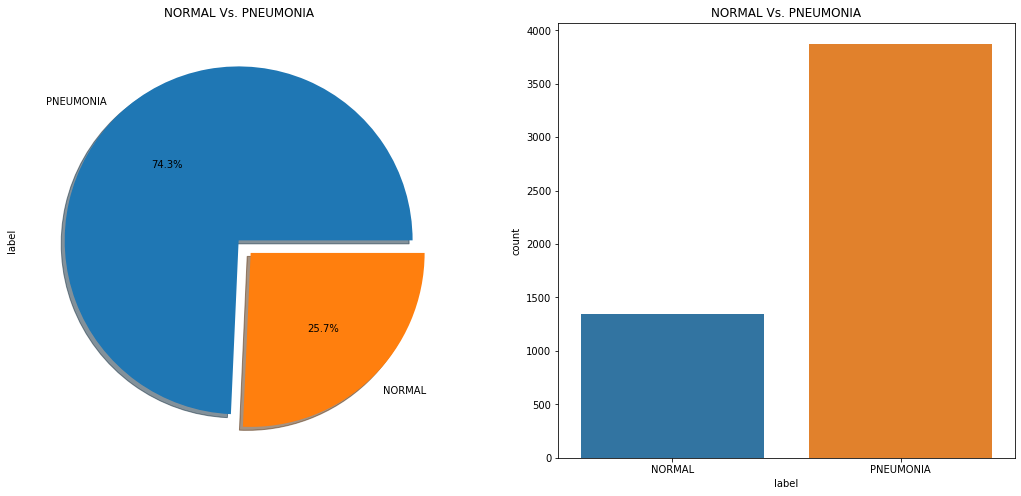

In [6]:
f,ax=plt.subplots(1,2,figsize=(18,8))
path_label_df['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('NORMAL Vs. PNEUMONIA')
sns.countplot(x=path_label_df['label'])
ax[1].set_title('NORMAL Vs. PNEUMONIA')
plt.show()

As we see that in the above figure we have an imbalanced dataset.
So we need different ways to measure the performance of the data. 


**Imbalanced DataSet**

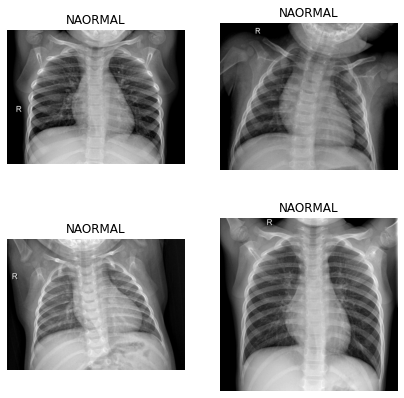

In [7]:
#Visualization of normal images
#sampling different 4 normal images randomly 

rand_normal_imgs = random.sample(normal_data, 4)

plt.figure(figsize=(7, 7))
for i in range(4):
    norm_img = Image.open(training_data_path/'NORMAL'/rand_normal_imgs[i])
    norm_img.resize(size=(180,180))
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(norm_img, cmap='gray')
    label = 'NORMAL'
    plt.title("NAORMAL")
    plt.axis("off")

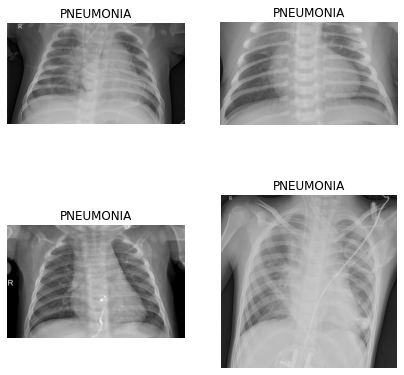

In [8]:
#Visualization of pneumonia images
#sampling different 4 pneumonia images randomly 

rand_pneumonia_imgs = random.sample(pneumonia_data, 4)

plt.figure(figsize=(7, 7))
for i in range(4):
    pneumonia_img = Image.open(training_data_path/'PNEUMONIA'/rand_pneumonia_imgs[i])
    pneumonia_img.resize(size=(180,180))
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(pneumonia_img, cmap='gray')
    label = 'PNEUMONIA'
    plt.title("PNEUMONIA")
    plt.axis("off")

As we can see from the above images, we **can not differentiate** between an infected and uninfected person by our **naked eyes**, 
so the task here to build a good classifier that will help to detect the infected person, this model will help save lives.

# 3- ImageDataGenerator

The data is stored as a jped files and it's should be formated as a floating point numbers befor feeding them to the 
network, so we should read the files, decoding then into RGB grids of pixels, convert them into floating point tensors, 
and rescaling them. The class `ImageDataGenerator` can automatically turn image files on disk into batches of floating point 
numbers ready for training using python generator.

We can get more data and fight overfitting by using data augmantation, by appling random transformations to the data using 
the `ImageDataGenerator` class also. 


`rotation_range`: randomly rotating the image. <br>
`zoom_range`: randomly zooming inside pictures. <br>
`horizontal_flip` , `vertical_flip`: randomly flipping half the half the images horizontally and vertically. <br>

**source:** Deep Learning with python by: Francois Chollet

In [9]:
img_height = 224
img_width = 224



training_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                                   rotation_range=0.2,
                                                                   zoom_range=0.2,
                                                                   horizontal_flip=True,
                                                                   vertical_flip=True)

training_generator = training_data_gen.flow_from_directory(training_data_path,
                                                          target_size=(img_height, img_width),
                                                          batch_size=32  ,
                                                          class_mode='binary')
#------------------------------------------------------------------------------------------------------
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
validation_generator = val_data_gen.flow_from_directory(testing_data_path,
                                                        target_size=(img_height, img_width),
                                                        batch_size=8,
                                                        class_mode='binary')
#------------------------------------------------------------------------------------------------------
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_generator = test_data_gen.flow_from_directory(validatoin_data_path,
                                                   target_size=(img_height, img_width),
                                                   batch_size=16,
                                                   class_mode='binary')
#------------------------------------------------------------------------------------------------------


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# 3- creating a simple model as a baseline

**define the convolutional base using a common pattern: a stack of `Conv2D` and `MaxPooling2D` layers.**

The CNN takes a tensor of shape (height, width, channels) 3D tensor (R, G, B) without givving it the batch size.
W will give the input shape to your first layer (180, 180, 3) by passing the argument `input_shape`.

**Source:** <a href="https://www.tensorflow.org/tutorials/images/cnn">Tensorflow Convolutional Neural Network (CNN)/<a>

In [10]:
baseline_model = tf.keras.models.Sequential()

baseline_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                                          activation='relu', input_shape=(224, 224, 3) ))
baseline_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))


baseline_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                          strides=(1, 1), activation='relu'))
baseline_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))


baseline_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3),
                                          strides=(1, 1), activation='relu'))
baseline_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))


baseline_model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3),
                                          strides=(1, 1), activation='relu'))
baseline_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

In [11]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

The output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). as we can see
the height and the width shrink as we go depper in the network, we can control the number of output channels 
by for each Conv2D by the first argument (e.g., filters=32)

**Source:** <a href="https://www.tensorflow.org/tutorials/images/cnn">Tensorflow Convolutional Neural Network (CNN)/<a>

**Add Dense layers on top**

Finally we will feed the last output tensor from the the convolutional base (of shape (20, 20, 64)) into Dense layers
that will perform the classification. First we need to Flatten the 3D tensor to 1D a `Flatten` layer, then we will add 
one or more dense layers on top of the flatten layer, we have 275 classes so the final dense layer 
will have 275 units.

**Source:** <a href="https://www.tensorflow.org/tutorials/images/cnn">Tensorflow Convolutional Neural Network (CNN)/<a>

The final layer I will use the softmax activations that used for multicalss classification, 
for the  layer that preceding the final layer I will use 512 units to avoid information bottleneck.


After the first two layers I will add `BatchNormalization` layer to reduce the danger of **Vanishing/Exploding Gradient** 
problems 

In [12]:
baseline_model.add(tf.keras.layers.Flatten())

baseline_model.add(tf.keras.layers.Dense(256, activation='relu',
                                        kernel_initializer='he_normal'))
baseline_model.add(tf.keras.layers.BatchNormalization())
baseline_model.add(tf.keras.layers.Dropout(0.4))

baseline_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [13]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

**Compile and train the model**

In [14]:
def decayed_learning_rate(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decayed_learning_rate)

#------------------------------------------------------------------------------------------------------

early_stopting = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 restore_best_weights=True,
                                                 patience=6)

In [17]:
baseline_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

baseline_history = baseline_model.fit(training_generator,
                                      steps_per_epoch=163,
                                      epochs=10, verbose = 1,
                                      validation_data=validation_generator,
                                      validation_steps=78, 
                                      callbacks=[lr_scheduler, early_stopting])

Epoch 1/10
163/163 [==============================] - 155s 944ms/step - loss: 0.3539 - accuracy: 0.8558 - val_loss: 0.7184 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 119s 730ms/step - loss: 0.2609 - accuracy: 0.9049 - val_loss: 0.5764 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 118s 724ms/step - loss: 0.2167 - accuracy: 0.9309 - val_loss: 1.0995 - val_accuracy: 0.4183
Epoch 4/10
163/163 [==============================] - 118s 724ms/step - loss: 0.2014 - accuracy: 0.9280 - val_loss: 0.7645 - val_accuracy: 0.6186
Epoch 5/10
163/163 [==============================] - 120s 737ms/step - loss: 0.1882 - accuracy: 0.9284 - val_loss: 0.2647 - val_accuracy: 0.8958
Epoch 6/10
163/163 [==============================] - 117s 715ms/step - loss: 0.1873 - accuracy: 0.9299 - val_loss: 0.3559 - val_accuracy: 0.8590
Epoch 7/10
163/163 [==============================] - 117s 717ms/step - loss: 0.2051 - accuracy: 0.9249 - val_loss: 0.2879 -

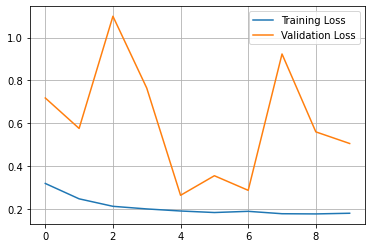

In [18]:
baseline_train_loss = baseline_history.history['loss']
baseline_val_loss = baseline_history.history['val_loss']


plt.plot(baseline_history.epoch, baseline_train_loss, label='Training Loss')
plt.plot(baseline_history.epoch, baseline_val_loss, label='Validation Loss')
plt.grid(True)
plt.legend()

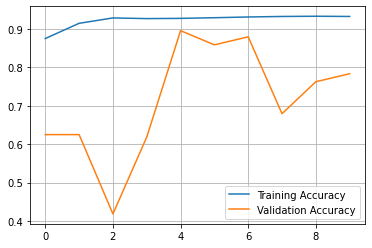

In [19]:
baseline_train_acc = baseline_history.history['accuracy']
baseline_val_acc = baseline_history.history['val_accuracy']

plt.plot(baseline_history.epoch, baseline_train_acc, label='Training Accuracy')
plt.plot(baseline_history.epoch, baseline_val_acc, label='Validation Accuracy')
plt.grid(True)
plt.legend()

In [20]:
baseline_testset_loss, baseline_testest_acc = baseline_model.evaluate(test_generator)
print("The test set loss: {}, Test set Accuracy: {}".format(baseline_testset_loss, baseline_testest_acc))

1/1 [==============================] - 0s 343ms/step - loss: 1.1485 - accuracy: 0.6250
The test set loss: 1.1484719514846802, Test set Accuracy: 0.625


In [21]:
print("And by now we have a baseline model to beat, The accuracy of the baseline model on the testset is {}".format(baseline_testest_acc))

And by now we have a baseline model to beat, The accuracy of the baseline model on the testset is 0.625


# 4- Implementing a simple ResNet CNN

Residual Network or (RezNet) won the ILSVRC 2015 challenge bt Kaiming He et al. the idea behind the RezNet is using a skip 
connections (shortcut connections), it works by adding the input signal the fed to the layer with the output of the layer, by these 
skip connections the signal can make its way across the network. The RezNet can be seen as a deep stack of Residual Units.

The Residual Unit composed of two Conv layers without pooling, BatchNormalization, Relu activation, 3 x 3 kernels, stride 1 and 
"same" padding. 


**source:** hands-on machine learning with scikit-learn, keras, and tensorflow: concepts, tools, and techniques to build intelligent systems
by: Aurélien Géron

by using the Residual Units we can train deeper network without suffering a problem of vanishing/Exploding gradient.

In [22]:
class ResidualUnit(tf.keras.layers.Layer):
    
    def __init__(self,filters, strides, activation, **kwargs):
        super().__init__(**kwargs)
        
        self.activation = tf.keras.activations.get(activation)
        
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, 
                                  padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, 
                                  padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization()]
        
        self.skip_con_layers = []
        if strides > 1:
            self.skip_con_layers = [
                tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, 
                                       padding='same', use_bias=False),
                tf.keras.layers.BatchNormalization()]
        
        
        def call(self, inputs):
            
            z = inputs 
            for layer in self.main_layers:
                z = layer(z)
                
            skip_z = inputs
            for layer in self.skip_con_layers:
                skip_z = layer(skip_z)
            
            return self.activation(z + skip_z)

In [23]:
simple_ResNet_model = tf.keras.models.Sequential()


simple_ResNet_model.add(tf.keras.layers.Conv2D(64, 7, strides=2, input_shape=(224,224,3),
                                       use_bias=False))
simple_ResNet_model.add(tf.keras.layers.MaxPool2D(pool_size=3))
simple_ResNet_model.add(tf.keras.layers.BatchNormalization())
simple_ResNet_model.add(tf.keras.layers.Activation('relu'))
simple_ResNet_model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))


simple_ResNet_model.add(ResidualUnit(filters=64, strides=1, activation='relu'))
simple_ResNet_model.add(ResidualUnit(filters=64, strides=1, activation='relu'))

simple_ResNet_model.add(ResidualUnit(filters=128, strides=2, activation='relu'))
simple_ResNet_model.add(ResidualUnit(filters=128, strides=1, activation='relu'))


simple_ResNet_model.add(tf.keras.layers.Flatten())
simple_ResNet_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

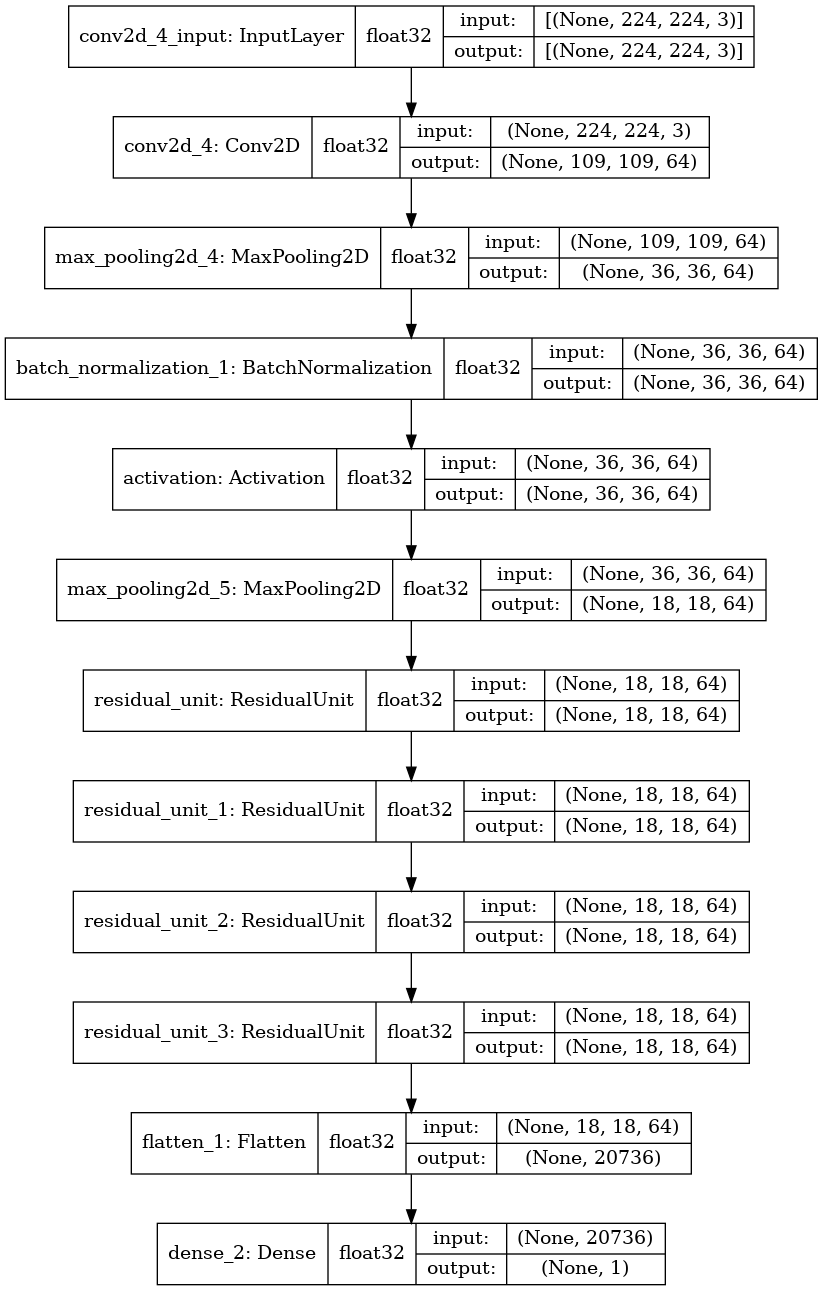

In [24]:
tf.keras.utils.plot_model(simple_ResNet_model,
                         show_shapes=True,
                         show_dtype=True,
                         show_layer_names=True,
                         expand_nested=True)

In [25]:
simple_ResNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 109, 109, 64)      9408      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 36, 36, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 18, 18, 64)        0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 18, 18, 64)       

As I mentioned this is an imabalanced data set and I explain in section 2 that we need to deal with this problem with 
different tools. 

As a metrics to measure I will use the following: `TruePositives`, `FalsePositives`, `TrueNegatives`, `FalseNegatives`,
`BinaryAccuracy`, `Precision`, `Recall`, and `AUC` to measure the performance of the model.

In [26]:
from tensorflow.keras import backend as K
def F1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

**Source:** <a href="https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d">Link to Souce of the F1_score code/<a>

In [27]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
    F1_score]

**Source:** <a href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data">Link to Souce of the METRICS code/<a>

In [28]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=750,
    decay_rate=0.92,
    staircase=True)

In [29]:
simple_ResNet_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                           loss=tf.keras.losses.BinaryCrossentropy(),
                           metrics=METRICS)

simple_ResNet_history = simple_ResNet_model.fit(training_generator,
                                                steps_per_epoch=163,
                                                epochs=15, 
                                                validation_data=validation_generator,
                                                validation_steps=78, 
                                                callbacks=[early_stopting])

Epoch 1/15
163/163 [==============================] - 119s 718ms/step - loss: 0.5025 - tp: 1799.2134 - fp: 195.6280 - tn: 470.1585 - fn: 174.8049 - accuracy: 0.8319 - precision: 0.8840 - recall: 0.8926 - auc: 0.8445 - prc: 0.9213 - F1_score: 0.8713 - val_loss: 0.4639 - val_tp: 379.0000 - val_fp: 141.0000 - val_tn: 93.0000 - val_fn: 11.0000 - val_accuracy: 0.7564 - val_precision: 0.7288 - val_recall: 0.9718 - val_auc: 0.9013 - val_prc: 0.9257 - val_F1_score: 0.8177
Epoch 2/15
163/163 [==============================] - 117s 719ms/step - loss: 0.2525 - tp: 1841.4878 - fp: 130.8171 - tn: 552.3537 - fn: 115.1463 - accuracy: 0.9101 - precision: 0.9355 - recall: 0.9432 - auc: 0.9544 - prc: 0.9800 - F1_score: 0.9384 - val_loss: 1.4811 - val_tp: 390.0000 - val_fp: 231.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6298 - val_precision: 0.6280 - val_recall: 1.0000 - val_auc: 0.8577 - val_prc: 0.8659 - val_F1_score: 0.7600
Epoch 3/15
163/163 [==============================] - 117s 7

**For test data:**

In [30]:
simple_ResNet_mode_results = simple_ResNet_model.evaluate(test_generator)

for name, value in zip(simple_ResNet_model.metrics_names, simple_ResNet_mode_results):
    print(name, ': ', value)
print()  

1/1 [==============================] - 0s 222ms/step - loss: 0.9178 - tp: 8.0000 - fp: 4.0000 - tn: 4.0000 - fn: 0.0000e+00 - accuracy: 0.7500 - precision: 0.6667 - recall: 1.0000 - auc: 0.8594 - prc: 0.8559 - F1_score: 0.8000
loss :  0.917782187461853
tp :  8.0
fp :  4.0
tn :  4.0
fn :  0.0
accuracy :  0.75
precision :  0.6666666865348816
recall :  1.0
auc :  0.859375
prc :  0.8558641672134399
F1_score :  0.7999999523162842



**For training data:**

positive: PNEUMONIA <br>
negative: NORMAL

In [31]:
actual_positive = len(os.listdir(training_data_path/'PNEUMONIA'))
actual_negative = len(os.listdir(training_data_path/'NORMAL'))
simple_ResNet_train_precision = simple_ResNet_history.history['precision'][0]
simple_ResNet_train_recall = simple_ResNet_history.history['recall'][0]
simple_ResNet_train_ROC_AUC = simple_ResNet_history.history['auc'][0]
simple_ResNet_train_prc = simple_ResNet_history.history['prc'][0]
simple_ResNet_train_F1_score = simple_ResNet_history.history['F1_score'][0]

print("The FalsePositives was {} out of {} that are truly negative that were calssified as positive.".format(simple_ResNet_history.history['fp'][0], actual_negative))
print("so we have a precesion of {}".format(simple_ResNet_train_precision))
print("\n")

print("The FalseNegatives was {} out of {} that are truly positive that were calssified as negative.".format(simple_ResNet_history.history['fn'][0], actual_positive))
print("so we have a recall of {}".format(simple_ResNet_train_recall))
print("\n")

print("The F1-score: {}".format(simple_ResNet_train_F1_score))
print("\n")

print("The Area Under the Curve of a Receiver Operating Characteristic curve ROC-AUC: {}".format(simple_ResNet_train_ROC_AUC))
print("And the Area Under the Curve of the Precision-Recall Curve prc: {}".format(simple_ResNet_train_prc))
print("\n")


The FalsePositives was 336.0 out of 1341 that are truly negative that were calssified as positive.
so we have a precesion of 0.9140005111694336


The FalseNegatives was 304.0 out of 3875 that are truly positive that were calssified as negative.
so we have a recall of 0.9215483665466309


The F1-score: 0.9122369885444641


The Area Under the Curve of a Receiver Operating Characteristic curve ROC-AUC: 0.918114185333252
And the Area Under the Curve of the Precision-Recall Curve prc: 0.961795449256897




**For Validation data** 

In [32]:
actual_positive = len(os.listdir(testing_data_path/'PNEUMONIA'))
actual_negative = len(os.listdir(testing_data_path/'NORMAL'))
simple_ResNet_val_precision = simple_ResNet_history.history['val_precision'][0]
simple_ResNet_val_recall = simple_ResNet_history.history['val_recall'][0]
simple_ResNet_val_ROC_AUC = simple_ResNet_history.history['val_auc'][0]
simple_ResNet_val_prc = simple_ResNet_history.history['val_prc'][0]
simple_ResNet_val_F1_score = simple_ResNet_history.history['val_F1_score'][0]

print("The FalsePositives was {} out of {} that are truly negative that were calssified as positive.".format(simple_ResNet_history.history['val_fp'][0], actual_negative))
print("so we have a precesion of {}".format(simple_ResNet_val_precision))
print("\n")

print("The FalseNegatives was {} out of {} that are truly positive that were calssified as negative.".format(simple_ResNet_history.history['val_fn'][0], actual_positive))
print("so we have a recall of {}".format(simple_ResNet_val_recall))
print("\n")

print("The F1-score: {}".format(simple_ResNet_val_F1_score))
print("\n")

print("The Area Under the Curve of a Receiver Operating Characteristic curve ROC-AUC: {}".format(simple_ResNet_val_ROC_AUC))
print("And the Area Under the Curve of the Precision-Recall Curve prc: {}".format(simple_ResNet_val_prc))
print("\n")

The FalsePositives was 141.0 out of 234 that are truly negative that were calssified as positive.
so we have a precesion of 0.7288461327552795


The FalseNegatives was 11.0 out of 390 that are truly positive that were calssified as negative.
so we have a recall of 0.971794843673706


The F1-score: 0.8177133798599243


The Area Under the Curve of a Receiver Operating Characteristic curve ROC-AUC: 0.901282012462616
And the Area Under the Curve of the Precision-Recall Curve prc: 0.9256938695907593




We can get best results using transfer learning and thats the next section topic.

But for this kind of problem diagnoses of illnesses, **it's better to have as lowest as possible of FalseNegatives**,
FalseNegatives is where the patient is actually have the disease (positive) but he diagnoses as negative (he don't have it)
because if the patient is trully have the disease we have to diagnoses his correctly and to undergo treatment. 

but in the other side it's okay ho have some FalsePositives where the patient is actually don't have the disease (negative) but he diagnoses as positive (he have it), because after more investigation the truth will come out. 

But mental health is also important, if we have a high FalsePositives and we tell a healthy patient that 
he has the disease we may harm his mental health for no reason. 


so we have to have a single metric that we can concentrate on which is the F1 score. 


# 5- Using pretrained models (Transfer learning (ResNet50V2))

Transfer learning is the process of taking the knowledge of pretrained model in different task or different domain 
to another domain or task. Task is defined by the input and the expected output (for example image classification 
and image detection are different tasks), while the domain (different data distributions but the same tasks),
for example when the task is image classification images taken fom the web and images by the user camera. 

**source:** Hands-On Computer Vision with TensorFlow 2 by: Benjamin Planche, Eliot Andres

As we know the first layers in the ConvNet learned local genaric features while higher layers extract more 
abstract concept, we can we can use this information and apply transfer learning.

<hr>


Here we are taking the convolutional base without the densly connected layer by setting `include_top`  to False

because the representations learned by the convolutional base are more genaric and reusable, which will be usefule 
regardless tho computer vision problem at hand, while the representations learned by the classifier are 
more specific to the classes which the model was trained. 

**source:** Deep Learning with Python by: Francois Chollet

<hr>


There are **two ways to use a pretrained models**:

- Feature Extraction <br>
- Fine Tuning <br>

**source:** Deep Learning with Python by: Francois Chollet

I will used the Fine Tuning method. 

<hr>

In [33]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False)

94674944/94668760 [==============================] - 1s 0us/step


<hr>

**steps for Fine-Tuning  a network:**
<ol>
<li>Add your custom network on top of an already-trained base network</li>
<li>Freeze the base netweork</li>
<li>Train the part you added</li>
<li>Un freeze some layers in the base network</li>
<li>Jointly train both these layers and the part you added</li>
</ol>


**Why we do the first 3 steps? why we just Un freeze some layers in the base network and directly Jointly train both these layers and the part you added?**

freezing the base netweork weights means preventing them from being updating during training, if we do not do this 
the presentations that was previesly learned by the base netweorkwill modified during trainin. 

The densw layers on the top that we added are randomly inialized and very large weight updated will be propagated through the 
network destroying the presentations that was previesly learned.

**source:** Deep Learning with Python by: Francois Chollet

In [34]:
TL_model = tf.keras.models.Sequential()

# step 1: Add your custom network on top of an already-trained base network
TL_model.add(base_model)
TL_model.add(tf.keras.layers.Flatten())
TL_model.add(tf.keras.layers.Dense(256, activation = 'relu'))
TL_model.add(tf.keras.layers.Dropout(0.3))
TL_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# step 2: Freeze the base netweork
base_model.trainable = False

In [35]:
# step 3: Train the part you added

TL_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)

TL_model_history = TL_model.fit(training_generator,
                                steps_per_epoch=163,
                                epochs=12, 
                                validation_data=validation_generator,
                                validation_steps=78)

Epoch 1/12
163/163 [==============================] - 129s 760ms/step - loss: 2.8321 - tp: 1802.3963 - fp: 153.6646 - tn: 545.6463 - fn: 154.0976 - accuracy: 0.8677 - precision: 0.9076 - recall: 0.9113 - auc: 0.8618 - prc: 0.9187 - F1_score: 0.9080 - val_loss: 0.3558 - val_tp: 376.0000 - val_fp: 42.0000 - val_tn: 192.0000 - val_fn: 14.0000 - val_accuracy: 0.9103 - val_precision: 0.8995 - val_recall: 0.9641 - val_auc: 0.9539 - val_prc: 0.9581 - val_F1_score: 0.9203
Epoch 2/12
163/163 [==============================] - 121s 745ms/step - loss: 0.1696 - tp: 1887.7744 - fp: 75.4939 - tn: 590.4085 - fn: 86.1280 - accuracy: 0.9403 - precision: 0.9627 - recall: 0.9580 - auc: 0.9756 - prc: 0.9895 - F1_score: 0.9594 - val_loss: 0.3213 - val_tp: 375.0000 - val_fp: 41.0000 - val_tn: 193.0000 - val_fn: 15.0000 - val_accuracy: 0.9103 - val_precision: 0.9014 - val_recall: 0.9615 - val_auc: 0.9582 - val_prc: 0.9633 - val_F1_score: 0.9220
Epoch 3/12
163/163 [==============================] - 123s 753ms

In [36]:
baseline_results = TL_model.evaluate(test_generator)

for name, value in zip(TL_model.metrics_names, baseline_results):
    print(name, ': ', value)
print()  

1/1 [==============================] - 0s 455ms/step - loss: 0.2943 - tp: 8.0000 - fp: 3.0000 - tn: 5.0000 - fn: 0.0000e+00 - accuracy: 0.8125 - precision: 0.7273 - recall: 1.0000 - auc: 0.9844 - prc: 0.9853 - F1_score: 0.8421
loss :  0.29432034492492676
tp :  8.0
fp :  3.0
tn :  5.0
fn :  0.0
accuracy :  0.8125
precision :  0.7272727489471436
recall :  1.0
auc :  0.984375
prc :  0.9852771162986755
F1_score :  0.8421052098274231



**Fine Tuning**

In [37]:
# step 4: Un freeze some layers in the base network

base_model.trainable = True 

set_trainable = False

for layer in base_model.layers:
    if layer.name == 'conv5_block3_preact_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else :
        layer.trainable = False

Here we use a **very low learning rate** to limit the magnitude of the modifications we make to the representations 
of the layers that we are fine tuning.

**source:** Deep Learning with Python by: Francois Chollet

In [38]:
# step 5: Jointly train both these layers and the part you added

TL_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)

TL_model_history = TL_model.fit(training_generator,
                                steps_per_epoch=163,
                                epochs=15, 
                                validation_data=validation_generator,
                                validation_steps=78,
                                callbacks=[early_stopting])

Epoch 1/15
163/163 [==============================] - 127s 751ms/step - loss: 0.5187 - tp: 1926.3537 - fp: 99.3659 - tn: 582.0915 - fn: 47.9939 - accuracy: 0.9409 - precision: 0.9441 - recall: 0.9781 - auc: 0.9524 - prc: 0.9700 - F1_score: 0.9607 - val_loss: 0.6745 - val_tp: 382.0000 - val_fp: 41.0000 - val_tn: 193.0000 - val_fn: 8.0000 - val_accuracy: 0.9215 - val_precision: 0.9031 - val_recall: 0.9795 - val_auc: 0.9475 - val_prc: 0.9469 - val_F1_score: 0.9305
Epoch 2/15
163/163 [==============================] - 121s 744ms/step - loss: 0.2282 - tp: 1906.0976 - fp: 48.8902 - tn: 632.2439 - fn: 52.5732 - accuracy: 0.9599 - precision: 0.9750 - recall: 0.9708 - auc: 0.9772 - prc: 0.9865 - F1_score: 0.9723 - val_loss: 0.8696 - val_tp: 383.0000 - val_fp: 46.0000 - val_tn: 188.0000 - val_fn: 7.0000 - val_accuracy: 0.9151 - val_precision: 0.8928 - val_recall: 0.9821 - val_auc: 0.9323 - val_prc: 0.9287 - val_F1_score: 0.9294
Epoch 3/15
163/163 [==============================] - 121s 741ms/ste

# 6- evaluation

In [39]:
baseline_results = TL_model.evaluate(test_generator)

for name, value in zip(TL_model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

1/1 [==============================] - 0s 284ms/step - loss: 0.4852 - tp: 7.0000 - fp: 3.0000 - tn: 5.0000 - fn: 1.0000 - accuracy: 0.7500 - precision: 0.7000 - recall: 0.8750 - auc: 0.9531 - prc: 0.9643 - F1_score: 0.7778
loss :  0.48515263199806213
tp :  7.0
fp :  3.0
tn :  5.0
fn :  1.0
accuracy :  0.75
precision :  0.699999988079071
recall :  0.875
auc :  0.953125
prc :  0.9642586708068848
F1_score :  0.7777777314186096



**For the training data**

In [40]:
actual_positive = len(os.listdir(training_data_path/'PNEUMONIA'))
actual_negative = len(os.listdir(training_data_path/'NORMAL'))
TL_model_train_precision = TL_model_history.history['precision'][0]
TL_model_train_recall = TL_model_history.history['recall'][0]
TL_model_train_ROC_AUC = TL_model_history.history['auc'][0]
TL_model_train_prc = TL_model_history.history['prc'][0]
TL_model_train_F1_score = TL_model_history.history['F1_score'][0]

print("The FalsePositives was {} out of {} that are truly negative that were calssified as positive.".format(TL_model_history.history['fp'][0], actual_negative))
print("so we have a precesion of {}".format(TL_model_train_precision))
print("\n")

print("The FalseNegatives was {} out of {} that are truly positive that were calssified as negative.".format(TL_model_history.history['fn'][0], actual_positive))
print("so we have a recall of {}".format(TL_model_train_recall))
print("\n")

print("The F1-score: {}".format(TL_model_train_F1_score))
print("\n")

print("The Area Under the Curve of a Receiver Operating Characteristic curve ROC-AUC: {}".format(TL_model_train_ROC_AUC))
print("And the Area Under the Curve of the Precision-Recall Curve prc: {}".format(TL_model_train_prc))
print("\n")


The FalsePositives was 166.0 out of 1341 that are truly negative that were calssified as positive.
so we have a precesion of 0.9579320549964905


The FalseNegatives was 103.0 out of 3875 that are truly positive that were calssified as negative.
so we have a recall of 0.9734741449356079


The F1-score: 0.9650031924247742


The Area Under the Curve of a Receiver Operating Characteristic curve ROC-AUC: 0.9598538279533386
And the Area Under the Curve of the Precision-Recall Curve prc: 0.9757317900657654




**For validation data**

In [41]:
actual_positive = len(os.listdir(testing_data_path/'PNEUMONIA'))
actual_negative = len(os.listdir(testing_data_path/'NORMAL'))
TL_model_val_precision = TL_model_history.history['val_precision'][0]
TL_model_val_recall = TL_model_history.history['val_recall'][0]
TL_model_val_ROC_AUC = TL_model_history.history['val_auc'][0]
TL_model_val_prc = TL_model_history.history['val_prc'][0]
TL_model_val_F1_score = TL_model_history.history['val_F1_score'][0]

print("The FalsePositives was {} out of {} that are truly negative that were calssified as positive.".format(TL_model_history.history['val_fp'][0], actual_negative))
print("so we have a precesion of {}".format(TL_model_val_precision))
print("\n")

print("The FalseNegatives was {} out of {} that are truly positive that were calssified as negative.".format(TL_model_history.history['val_fn'][0], actual_positive))
print("so we have a recall of {}".format(TL_model_val_recall))
print("\n")

print("The F1-score: {}".format(TL_model_val_F1_score))
print("\n")

print("The Area Under the Curve of a Receiver Operating Characteristic curve ROC-AUC: {}".format(TL_model_val_ROC_AUC))
print("And the Area Under the Curve of the Precision-Recall Curve prc: {}".format(TL_model_val_prc))
print("\n")

The FalsePositives was 41.0 out of 234 that are truly negative that were calssified as positive.
so we have a precesion of 0.9030733108520508


The FalseNegatives was 8.0 out of 390 that are truly positive that were calssified as negative.
so we have a recall of 0.9794871807098389


The F1-score: 0.9304908514022827


The Area Under the Curve of a Receiver Operating Characteristic curve ROC-AUC: 0.9475400447845459
And the Area Under the Curve of the Precision-Recall Curve prc: 0.9469319581985474




In [42]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

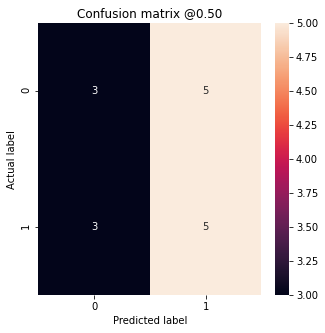

In [43]:
predictions = TL_model.predict(test_generator)
plot_cm(test_generator.labels, predictions, p=0.5)

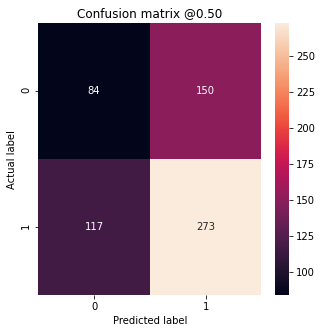

In [44]:
predictions = TL_model.predict(validation_generator)
plot_cm(validation_generator.labels, predictions, p=0.5)

In [45]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

positive: PNEUMONIA <br>
negative: NORMAL